# <center>`Unsupervised Learning`<center>
    
###### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
import scipy.stats as stats

###### Read the data

In [2]:
df = pd.read_csv('Data/filled_train_28-03.csv')
df['Months_Since_Deliquency'] = df['Months_Since_Deliquency'].fillna(360)
df.head()

Loan_Amount_Requested  Length_Employed  Annual_Income  Debt_To_Income  \
0                 7000.0              0.0        68000.0            18.0   
1                30000.0              4.0        98367.0            15.0   
2                24725.0              7.0        75566.0            16.0   
3                17000.0              8.0        96000.0            22.0   
4                 4500.0              2.0        30000.0            11.0   

   Inquiries_Last_6Mo  Number_Open_Accounts  Total_Accounts Home_Owner  \
0                 0.0                   9.0            14.0       Rent   
1                 0.0                  12.0            24.0   Mortgage   
2                 0.0                  12.0            16.0   Mortgage   
3                 1.0                  19.0            30.0        Own   
4                 1.0                  12.0            15.0       Rent   

     Income_Verified     Purpose_Of_Loan  Gender  Months_Since_Deliquency  \
0       not verified                 car  Female                    360.0   
1  VERIFIED - income  debt_consolidation  Female                     17.0   
2  VERIFIED - income  debt_consolidation    Male                    360.0   
3  VERIFIED - income  debt_consolidation  Female                    360.0   
4  VERIFIED - income         credit_card    Male                    360.0   

   Interest_Rate  
0              1  
1              3  
2              3  
3              1  
4              3

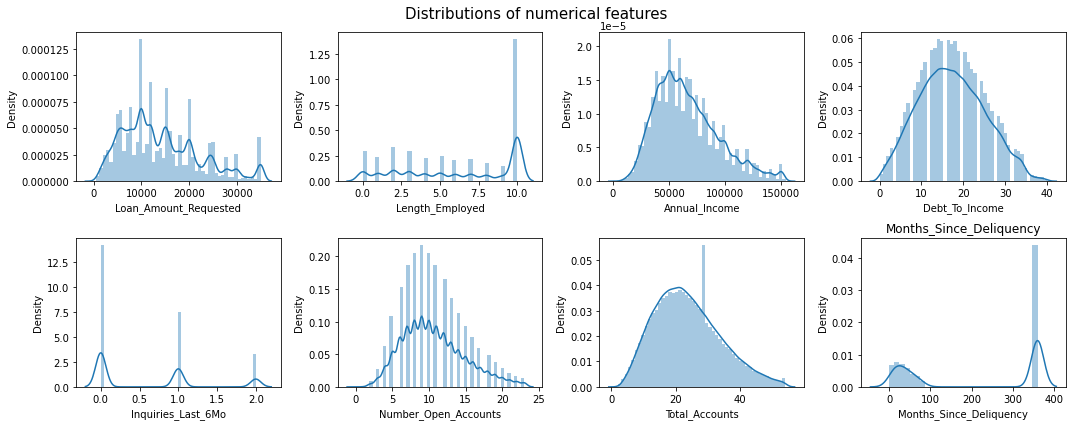

In [3]:
data_dist = df.select_dtypes(np.number).drop('Interest_Rate',axis = 1)
fig,ax = plt.subplots(nrows = 2,ncols = 4,figsize = (15,6))
for variables,plotsubs in zip(data_dist.columns,ax.flatten()):
    plt.title(variables)
    plotsubs.tick_params(labelsize = 10)
    plotsubs.set_xlabel(variables,fontsize = 10)
    sns.distplot(df[variables],ax = plotsubs)
    plt.tight_layout()
    plt.subplots_adjust(top = 0.92) 
fig.suptitle('Distributions of numerical features',fontsize = 15)
plt.show()

###### Making same transformations as in Classification notebook

In [3]:
data1 = df.copy()

In [4]:
data1['Loan_Amount_Requested'] = np.sqrt(data1['Loan_Amount_Requested'])
data1['Annual_Income'] = stats.boxcox(data1['Annual_Income'])[0]
data1['Number_Open_Accounts'] = np.sqrt(data1['Number_Open_Accounts'])
data1['Total_Accounts'] = np.sqrt(data1['Total_Accounts'])
data1['Months_Since_Deliquency'] = np.log(abs(df['Months_Since_Deliquency']-np.mean(df['Months_Since_Deliquency'])))
#Months_Since_Deliquency is sort of multi-modal

In [5]:
# def emp(x):
#     if x>=10:
#         return '10+yrs'
#     elif x>=6 and x<=9:
#         return '6-9 yrs'
#     elif x>=2 and x<=5:
#         return '2-5 yrs'
#     else:
#         return '0-1 yrs'

# data1['Length_Employed'] = data1['Length_Employed'].apply(emp)

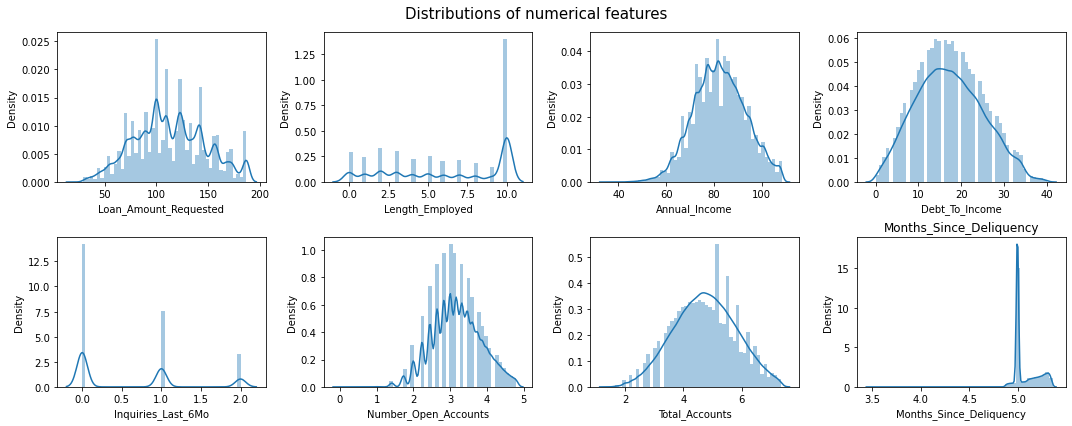

In [7]:
data_dist = data1.select_dtypes(np.number).drop('Interest_Rate',axis = 1)
fig,ax = plt.subplots(nrows = 2,ncols = 4,figsize = (15,6))
for variables,plotsubs in zip(data_dist.columns,ax.flatten()):
    plt.title(variables)
    plotsubs.tick_params(labelsize = 10)
    plotsubs.set_xlabel(variables,fontsize = 10)
    sns.distplot(data_dist[variables],ax = plotsubs)
    plt.tight_layout()
    plt.subplots_adjust(top = 0.92) 
fig.suptitle('Distributions of numerical features',fontsize = 15)
plt.show()

In [5]:
#Instead of using OneHotEncoder, we will be using label encoder here since magnitude would not matter in USL
data1.drop('Interest_Rate',axis = 1,inplace = True)

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in data1.select_dtypes('object').columns:
    data1[i] = le.fit_transform(data1[i])

###### Standardizing the dataset

In [7]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
data_scaled = pd.DataFrame(ss.fit_transform(data1),columns = data1.columns)

###### Data is now ready for applying Unsupervised learning techniques

###### K-Means Clustering

In [22]:
from sklearn.cluster import KMeans
wcv = []
for i in range(1,10):
    km = KMeans(n_clusters = i)
    km.fit(data_scaled)
    wcv.append(km.inertia_)

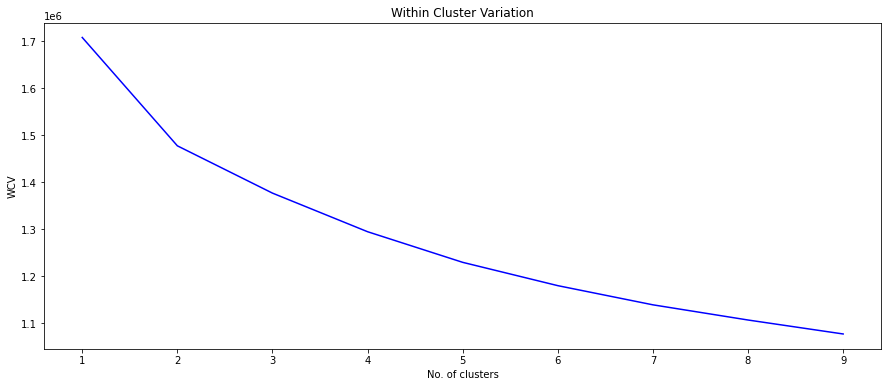

In [23]:
plt.figure(figsize = (15,6))
plt.title('Within Cluster Variation')
plt.plot(range(1,10),wcv,color = 'b')
plt.xlabel('No. of clusters')
plt.ylabel('WCV')
plt.show()

In [43]:
#Optimum number of clusters are 2,3 or 4. Since our dataset had 3 clusters in the begining we will be going with
#3 clusters.
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 3)
km.fit(data_scaled)
target1 = pd.Series(km.predict(data_scaled),name = 'Interest_Rate')

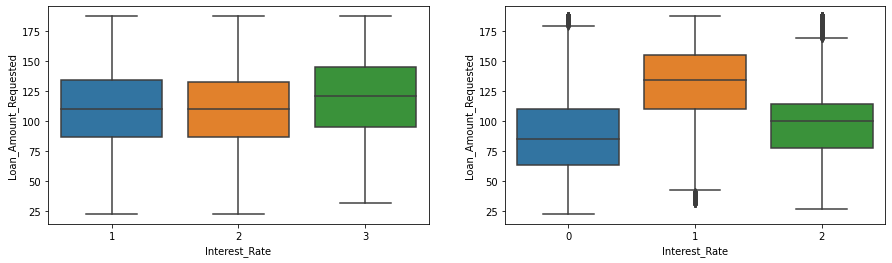

In [45]:
fig,ax = plt.subplots(1,2,figsize = (15,4))
comp = 'Loan_Amount_Requested'
targ = 'Interest_Rate'
sns.boxplot(df[targ],data1[comp],ax = ax[0])
sns.boxplot(target1,data1[comp],ax = ax[1])
plt.show()

In [46]:
df['Interest_Rate'].value_counts()

2    62405
3    49957
1    29937
Name: Interest_Rate, dtype: int64

In [48]:
#Using loan amount requested to rename the predicted target
target1.value_counts()

1    68290
2    59513
0    14496
Name: Interest_Rate, dtype: int64

In [49]:
target1.map({0:1,1:2,2:3}).value_counts()

2    68290
3    59513
1    14496
Name: Interest_Rate, dtype: int64

In [53]:
df[df['Interest_Rate']==target1.map({0:1,1:2,2:3})].shape
#We see 48874 values that match with the original target variable. This could explain the low accuracy in the 
#classification models.

(48874, 13)

In [54]:
target1 = target1.map({0:1,1:2,2:3})

###### Hierarchial Clustering

In [8]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

In [ ]:
X_a = data_scaled.sample(35000)
plt.figure(figsize = (15,6))
sch.dendrogram(sch.linkage(X_a,'ward'),p = 10, truncate_mode = 'level')
plt.show()

###### Trying KMeans with PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(data_scaled)
len(np.cumsum(pca.explained_variance_ratio_)[np.cumsum(pca.explained_variance_ratio_)<=0.95])
#10 components tends to preserve 95% of variance

In [ ]:
pca = PCA(n_components = 0.95)
X_pca = pca.fit_transform(data_scaled)

In [97]:
from sklearn.cluster import KMeans
wcv = []
for i in range(1,10):
    km = KMeans(n_clusters = i)
    km.fit(X_pca)
    wcv.append(km.inertia_)

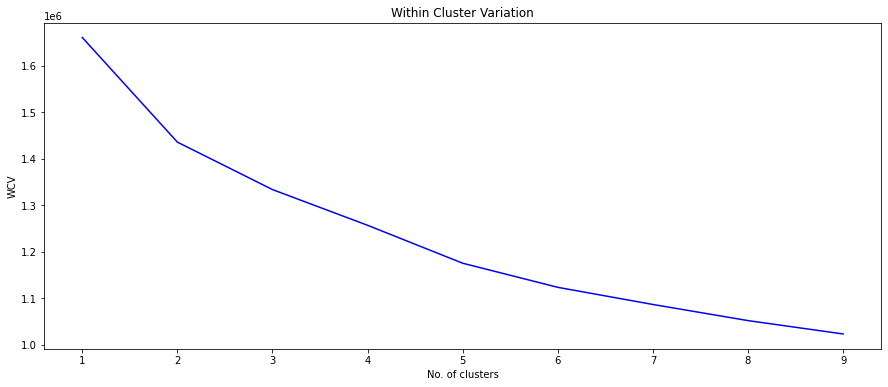

In [98]:
plt.figure(figsize = (15,6))
plt.title('Within Cluster Variation')
plt.plot(range(1,10),wcv,color = 'b')
plt.xlabel('No. of clusters')
plt.ylabel('WCV')
plt.show()

In [57]:
#Optimum number of clusters are 2,3 or 4. Since our dataset had 3 clusters in the begining we will be going with
#3 clusters.
km = KMeans(n_clusters = 3)
km.fit(X_pca)
target2 = pd.Series(km.predict(X_pca))

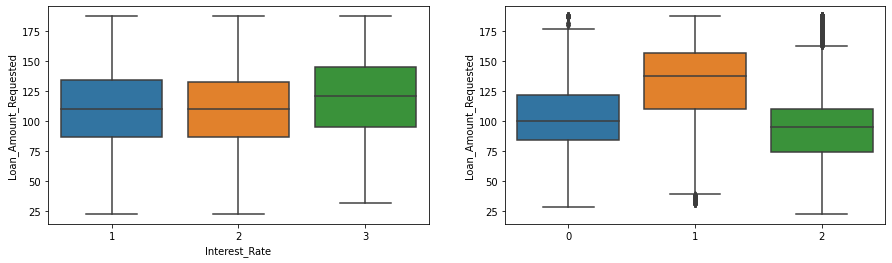

In [58]:
fig,ax = plt.subplots(1,2,figsize = (15,4))
comp = 'Loan_Amount_Requested'
targ = 'Interest_Rate'
sns.boxplot(df[targ],data1[comp],ax = ax[0])
sns.boxplot(target2,data1[comp],ax = ax[1])
plt.show()

In [59]:
#Using loan amount requested to rename the predicted target
target2.value_counts()

1    62784
2    46022
0    33493
dtype: int64

In [60]:
df['Interest_Rate'].value_counts()

2    62405
3    49957
1    29937
Name: Interest_Rate, dtype: int64

In [68]:
target2.map({0:1,1:2,2:3}).value_counts()

2    62784
3    46022
1    33493
dtype: int64

In [69]:
df[df['Interest_Rate']==target2.map({0:1,1:2,2:3})].shape
#In case of PCA data, we see 52K targets that match with the original target. 
#This is better than before but still this is not great for our original target.

(52818, 13)

###### Inference

* The mismatch in the original target variable and our created target variable could explain the underperformance of all ML algorithms in classification. Not reducing dimensions tends to better mimic the original target variable.

In [75]:
target2 = pd.Series(target2.map({0:1,1:2,2:3}),name = 'Interest_Rate')

###### Hierarchial Clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

In [ ]:
X_a_pca = pd.DataFrame(X_pca).sample(35000)
plt.figure(figsize = (15,6))
sch.dendrogram(sch.linkage(X_a_pca,'ward'),p = 10, truncate_mode = 'level')
plt.show()

In [77]:
df_class = pd.concat((data1,target2),axis = 1)

In [78]:
df_class.to_csv('Data/clusters_obtained.csv',index = False)

# Applying Classification Algorithm the data with new target

In [81]:
df = pd.read_csv('Data/clusters_obtained.csv')
df.head()

Loan_Amount_Requested  Length_Employed  Annual_Income  Debt_To_Income  \
0              83.666003              0.0      84.824098            18.0   
1             173.205081              4.0      94.869560            15.0   
2             157.241852              7.0      87.584961            16.0   
3             130.384048              8.0      94.172943            22.0   
4              67.082039              2.0      66.067455            11.0   

   Inquiries_Last_6Mo  Number_Open_Accounts  Total_Accounts  Home_Owner  \
0                 0.0              3.000000        3.741657           4   
1                 0.0              3.464102        4.898979           0   
2                 0.0              3.464102        4.000000           0   
3                 1.0              4.358899        5.477226           3   
4                 1.0              3.464102        3.872983           4   

   Income_Verified  Purpose_Of_Loan  Gender  Months_Since_Deliquency  \
0                1                0       0                 4.995113   
1                0                2       0                 5.274590   
2                0                2       1                 4.995113   
3                0                2       0                 4.995113   
4                0                1       1                 4.995113   

   Interest_Rate  
0              3  
1              2  
2              2  
3              2  
4              3

###### Train_Test_Split

In [119]:
from sklearn.model_selection import train_test_split
X = df.drop('Interest_Rate',axis =1)
y = df['Interest_Rate']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 1)
np.mean(y_train),np.mean(y_test) #Train,test split is ok

(2.090715835522097, 2.077371749824315)

###### Standardizing for LogisticRegression

In [120]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_scaled = pd.DataFrame(ss.fit_transform(X),columns = X.columns)

X_train_s,X_test_s,y_train,y_test = train_test_split(X_scaled,y,test_size = 0.2,random_state = 1)
np.mean(y_train),np.mean(y_test) #Train,test split is ok

(2.090715835522097, 2.077371749824315)

###### Logistic Regression (Unscaled data)

In [127]:
#Applying logistic regression from sklearn
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)
pred = lr.predict(X_test)

p_const = [1 if i<=1 else 2 if i>1 and i<=2.5 else 3 for i in pred]

In [128]:
from sklearn.metrics import classification_report
print(classification_report(y_test,p_const))
#Immediately we see an improvement in accuracy to 69% as compared to 46% which we achieved from our base model

              precision    recall  f1-score   support

           1       0.98      0.16      0.27      6849
           2       0.59      0.96      0.73     12560
           3       0.93      0.71      0.81      9051

    accuracy                           0.69     28460
   macro avg       0.83      0.61      0.60     28460
weighted avg       0.79      0.69      0.64     28460



###### Logistic Regression (scaled data)

In [129]:
#Applying logistic regression from sklearn
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train_s,y_train)
pred = lr.predict(X_test_s)

p_const_s = [1 if i<=1 else 2 if i>1 and i<=2.5 else 3 for i in pred]

In [130]:
from sklearn.metrics import classification_report
print(classification_report(y_test,p_const_s))
#Immediately we see an improvement in accuracy to 69% as compared to 46% which we achieved from our base model

              precision    recall  f1-score   support

           1       0.98      0.16      0.27      6849
           2       0.59      0.96      0.73     12560
           3       0.93      0.71      0.81      9051

    accuracy                           0.69     28460
   macro avg       0.83      0.61      0.60     28460
weighted avg       0.79      0.69      0.64     28460



###### Initializing model_function

In [131]:
from sklearn.model_selection import cross_val_score

def model_function(estimator,X,y):
    
    f1 = cross_val_score(estimator,X,y,cv = 5,scoring = 'f1_weighted',n_jobs = -1)
    accuracy = cross_val_score(estimator,X,y,cv = 5,scoring = 'accuracy',n_jobs = -1)
    
    return round(np.mean(f1),2),round(np.mean(accuracy),2),estimator

In [138]:
# !pip install lightgbm

In [141]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [111]:
f1_all = []
accuracy_all = []
model_name = []

In [153]:
#Creating a list with all models
dtc  =   DecisionTreeClassifier(random_state=5)
nb   =   MultinomialNB()
etc  =   ExtraTreesClassifier(random_state=5)
rfc  =   RandomForestClassifier(random_state=5)
gbc  =   GradientBoostingClassifier(random_state=5)
abc  =   AdaBoostClassifier(random_state=5)
lgbc =   LGBMClassifier(objective='multiclass', random_state=5,task_type = 'GPU')
xgbc =   XGBClassifier(random_state=5,task_type = 'GPU')
cbc  =   CatBoostClassifier(random_state = 5,task_type = 'GPU')

models = [dtc,nb,etc,rfc,gbc,abc,lgbc,xgbc,cbc]

###### Running all models to see which algorithm gives us good scores.

In [116]:
for i in models:
    f1,accuracy,estimator = model_function(i,X,y)
    f1_all.append(f1)
    accuracy_all.append(accuracy)
    model_name.append(estimator)

In [117]:
pd.DataFrame({'Model':model_name,'Accuracy':accuracy_all,'F1 Score': f1_all})

Model  Accuracy  F1 Score
0  DecisionTreeClassifier()      0.94      0.94
1  RandomForestClassifier()      0.97      0.97

In [ ]:
#On our classified data, all algorithms seem to do very well.